In [104]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import json
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from g4f.client import Client
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None) 

После достаточного парсинга появилось дополнительное описание продукта/создателя и его опыт. Эти данные будут смерджены с общим предобработанным датасетом для создания дополнительных универсальных фич (зависимых от описания)


In [5]:
import pandas as pd 
df = pd.read_excel("data/test.xlsx")
df_pred = pd.read_csv("data/version_first_preprocessed.csv")


In [6]:
df.iloc[1]

project_desc    Story\n\nPassionate Innovator Unveils Patent-Pending Swirl Scrubber™ to Transform Skincare\n\nEnd moldy messes! The Swirl Scrubber body scrubber’s embedded anti-microbial silver ions reduce bacteria buildup by 99.9% while fluid mechanics provide unprecedented precision cleansing of moist environments prone to mold - perfect for busy family bathrooms.\n\nRichard Davidson knows first-hand the immense impact even incremental skincare improvements impart on quality-of-life having created beloved brand Truly Clear by harnessing advancements combatting common skin conditions. Now, driven by deep conviction in the perpetual progress pipeline for scientific breakthroughs benefiting skincare, this creative inventor unveils his greatest advancement yet: the Swirl Scrubber™.  \n\nThis first-ever premium body scrubber leverages proprietary fluid vortex technology, unprecedented in consumer applications, to customize and optimize previously uniform aspects of something as universal 

In [7]:
def get_nums(s):
    if isinstance(s, str) and len(s.split()) > 1:
        return int(s.split()[1])
    return 0

In [8]:
df.loc[df['Nums_created'] == 'Comments', 'Nums_created'] = df['Nums_backed']
df['Nums_backed'] = df['Nums_backed'].fillna('')
df.loc[df['Nums_backed'].str.startswith('Created'), 'Nums_backed'] = None

df['Nums_created'] = df['Nums_created'].apply(get_nums)
df['Nums_backed'] = df['Nums_backed'].apply(get_nums) 

In [9]:
result_df = pd.merge(df, df_pred, left_on="Category", right_on="urls", how="inner")

In [10]:
# Переведу из строчного в целочисленный тип
result_df[['Nums_backed', 'Nums_created']] = result_df[['Nums_backed', 'Nums_created']].astype('int64')

In [11]:
# Объединю 2 столбца в общее описание
result_df['full_desc'] = "Startup description: " + result_df['project_desc'] + " Created at: " + result_df['created_at'] + " Creator description: " + result_df['creator_desc']

In [12]:
result_df['creator'].value_counts().head(20)

creator
césar vidal                          14
test_unknown                         13
letbia rejon                         12
ryan danhauser                       10
per johansson & eric schüldt          8
nandita godbole                       7
bret juliano                          6
navid modiri                          6
such ffun                             6
zauberfeder                           6
sanzaki kojika                        5
hidizs                                5
tuco el buitre                        5
david willis                          5
kelci d crawford                      5
lisa bjärbo & johanna lindbäck        4
alternative blacks                    4
n.m. bell                             4
cici bellis                           4
ralf christensen og kristian leth     4
Name: count, dtype: int64

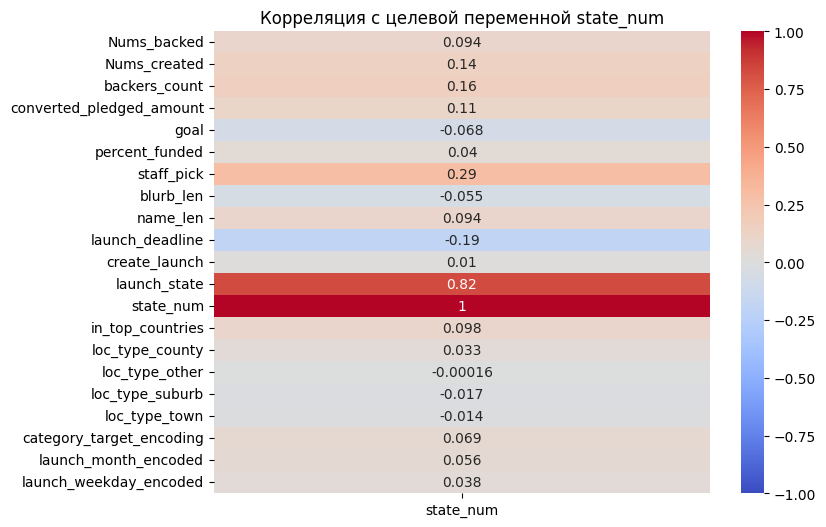

In [13]:
numeric_columns = result_df.select_dtypes(include=['number']).columns.tolist()
categorical_columns = result_df.select_dtypes(exclude=['number']).columns.tolist()
# Корреляционный анализ

correlation_matrix = result_df[numeric_columns].corr()

# Выбор корреляции с целевой переменной 'state_num'
correlation_with_target = correlation_matrix[['state_num']]

# Построение тепловой карты корреляции
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция с целевой переменной state_num')
plt.show()

In [129]:
# result_df.to_csv('full_data_test.csv')

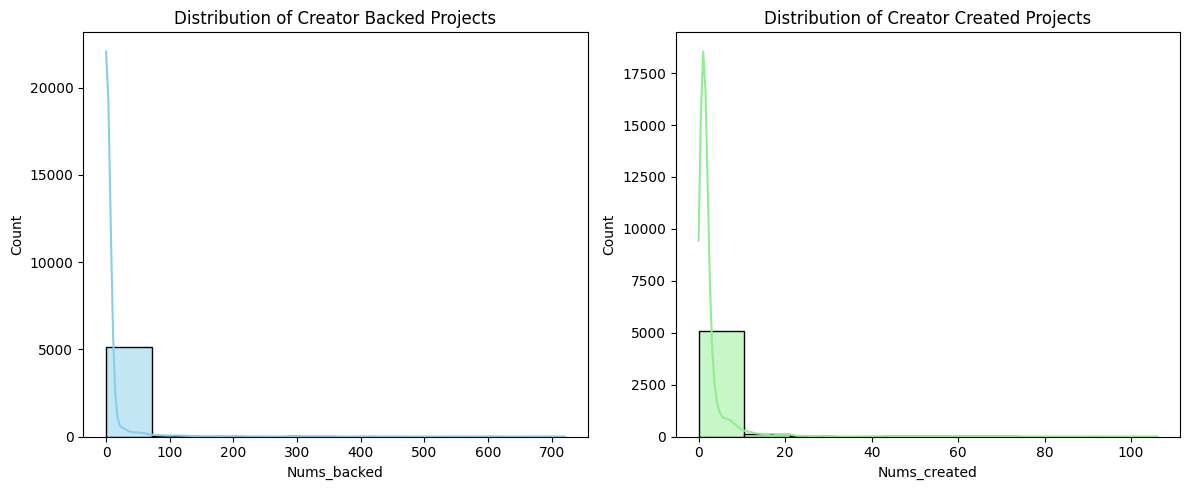

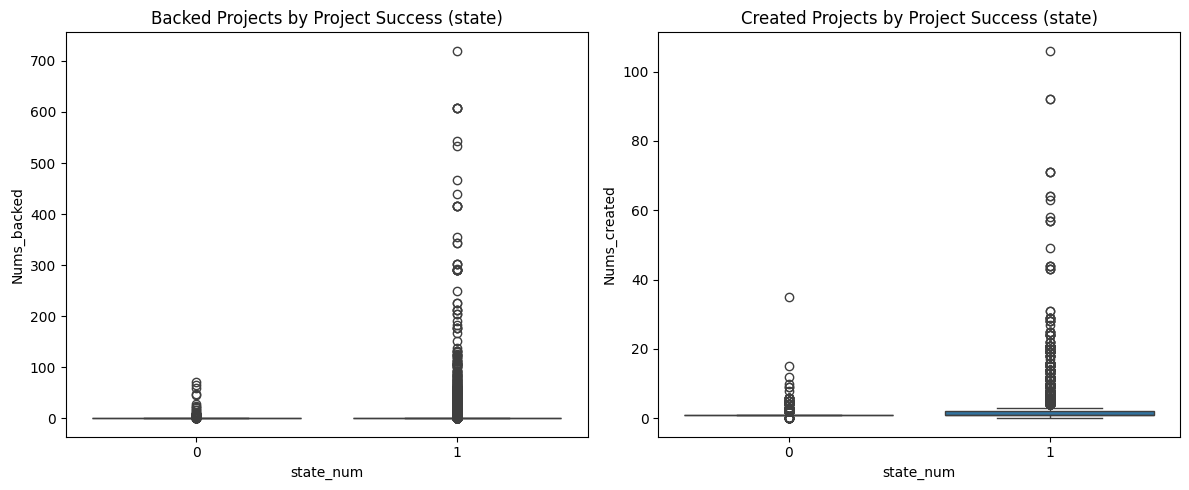

(       Nums_backed  Nums_created
 count      5260.00       5260.00
 mean          5.77          2.48
 std          34.55          5.03
 min           0.00          0.00
 25%           0.00          1.00
 50%           0.00          1.00
 75%           0.00          2.00
 max         720.00        106.00,
               Nums_backed  Nums_created  state_num
 Nums_backed          1.00          0.43       0.09
 Nums_created         0.43          1.00       0.14
 state_num            0.09          0.14       1.00)

In [130]:
desc_stats = result_df[['Nums_backed', 'Nums_created']].describe()

# 2. Correlation with the target variable 'state'
correlation_with_success = result_df[['Nums_backed', 'Nums_created', 'state_num']].corr()

# 3. Visualizations

# Histograms for both 'creator_backed_projects' and 'creator_created_projects'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(result_df['Nums_backed'], kde=True, bins=10, color='skyblue')
plt.title('Distribution of Creator Backed Projects')

plt.subplot(1, 2, 2)
sns.histplot(result_df['Nums_created'], kde=True, bins=10, color='lightgreen')
plt.title('Distribution of Creator Created Projects')

plt.tight_layout()
plt.show()

# 4. Boxplots for 'creator_backed_projects' and 'creator_created_projects' by 'state'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='state_num', y='Nums_backed', data=result_df)
plt.title('Backed Projects by Project Success (state)')

plt.subplot(1, 2, 2)
sns.boxplot(x='state_num', y='Nums_created', data=result_df)
plt.title('Created Projects by Project Success (state)')

plt.tight_layout()
plt.show()

# Output descriptive stats and correlation
desc_stats, correlation_with_success

In [131]:
result_df.head(1)['full_desc']

0    Startup description: Story\n\nKonflikten i östra Ukraina har pågått i snart två år. Efter demonstrationerna i Kiev i slutet av 2013 började det som har kommit att bli en utdragen konflikt. Många civila tvingades lämna sina hem för flykten men vissa hade inget annat val än att stanna kvar.\n\nJag vill berätta om de som har stannat kvar. Som inte hade någonstans att ta vägen, eller pengar nog för att slita sig från sina rötter.\n\nÄven om färre granater landar bland lägenheter och hus idag så lever civilbefolkningen fortfarande i en otrygg miljö. Intresset från omvärlden har också svalnat.\n\nDärför tycker jag att det är viktigt med berättelser från östra Ukraina. Med bilden som verktyg vill jag visa hur det är att leva i Donetsk och min uppfattning är det finns fler än jag som vill veta hur konflikten har drabbat människorna som bor kvar där. Hur fungerar deras vardag och vad är det som gör att de inte kan lämna sina hem för en säkrare plats?\n\nI början av 2016 kommer jag att följ

Как идея я захотел добавить фичей, который зависят от самого описания продукта/создателя.  
Цель - выделить универсальные оценки.   
Для этого предприняты следующие действия:  
Новые фичи будут заполняться с помощью LLM с техникой Подсказка по цепочке рассуждений, где LLM представляется с серией вопросов, предназначенных для получения конкретных инсайтов по различным аспектам потенциала стартапа для успеха (размер рынка, рост отрасли, соответсвие продукта рынку, опыт создателя и т.п.)  
Условно мне нужно провести оценку от описания самого создателя и стартапа, но нет возможности попросить специалистов по оценке проектов разметить по фичам. В данном случае специалистом будет выступать LLM.


In [132]:
def get_response(sys_content, usr_content, model):
    client = Client()
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": sys_content},
            {"role": "user", "content": usr_content}
        ],
        # stream=True
    )
    return completion.choices[0].message.content

def process_row(row, sys_content, model):
    desc = row['full_desc']
    index = row.name
    categories = get_response(sys_content, desc, model)
    
    if categories:
        try:
            # Пробуем распарсить JSON
            startup_info = json.loads(categories)
            return index, startup_info  # Возвращаем индекс и данные
        except json.JSONDecodeError:
            # Если ошибка JSON, возвращаем индекс и None
            return index, None  
    return index, None  # Возвращаем индекс и None, если нет категорий

def add_features_from_js(df, sys_content, model):
    # Список для ID строк с ошибками
    error_ids = []
    
    # Пустой список для хранения новых данных по строкам
    new_data = []
    
    # Для отображения прогресса
    index_1 = 0
    for _, row in df.iterrows():
        index_1 += 1
        retries = 0
        max_retries = 3
        json_data = None

        while json_data is None and retries < max_retries:
            index, json_data = process_row(row, sys_content, model)  # Убедитесь, что оба значения возвращаются
            retries += 1
            
            if json_data is None:
                time.sleep(1)
        
        if json_data is None:
            # Если после нескольких попыток не удалось, сохраняем ID строки с ошибкой
            error_ids.append(index)
        else:
            # Добавляем распарсенные данные в список
            new_data.append(json_data)

        print(f'\rProcessed row {index_1}/{len(df)}', end='')

    # Создаем новый DataFrame с сохранением индексов из исходного DataFrame
    new_features_df = pd.DataFrame(new_data, index=df.index[:len(new_data)])
    
    return new_features_df, error_ids

In [134]:
model_content_1 = '''
Analyze the startup based on the following criteria. Answer each question using only one of the predefined categories. Only return the JSON response based on your analysis, and do not repeat this instruction or provide any other text.

Questions:
1) "Is the startup operating in a growing industry?"
2) "Is the market size of the startup's product/service considered large?"
3) "Does the startup demonstrate rapid growth compared to competitors?"
4) "Is the startup considered adaptable to market changes?"
5) "How do you assess the startup's execution capabilities?"
6) "Are well-known investors or venture firms backing the startup?"
7) "Do market research indicate a strong product-market fit for the startup?"
8) "Does sentiment analysis of founder and company descriptions suggest high positivity?"
9) "Are innovations frequently mentioned in public company communications?"
10) "Does the startup mention cutting-edge technologies in its descriptions?"
11) "Given the startup's industry and current market conditions (or conditions at the time of founding), is it the right time for the startup's product or service?"
12) "How experienced is startup's execution?"
13) "Is the creator capable of envisioning strategic development?"
14) "How are the creator's management skills assessed?"

Answer using the following options:
1)[Yes/No/N/A]
2)[Small/Medium/Large/No answer]
3)[Slower/Same/Faster/No answer]
4)[Not adaptable/Relatively adaptable/Very adaptable/No answer]
5)[Poor/Average/Excellent/No answer]
6)[Unknown/Known/Highly valued/No answer]
7)[Weak/Moderate/Strong/No answer]
8)[Negative/Neutral/Positive/No answer]
9)[Rarely/Sometimes/Often/No answer]
10)[No/Mentioned/Highlighted/No answer]
11)[Too early/Just right/Too late/No answer]
12)[Low/Medium/High/No answer]
13)[Limited/Moderate/Strong/No answer]
14)[Weak/Average/Strong/No answer]

Respond only in the following JSON format based on your analysis (with new values, not repeating this instruction), **in English**:
{
    "startup_analysis_responses": {
        "industry_growth": "Your answer",
        "market_size": "Your answer",
        "development_pace": "Your answer",
        "market_adaptability": "Your answer",
        "execution_capabilities": "Your answer",
        "investor_backing": "Your answer",
        "product_market_fit": "Your answer",
        "sentiment_analysis": "Your answer",
        "innovation_mentions": "Your answer",
        "cutting_edge_technology": "Your answer",
        "timing": "Your answer",
        "creator_experience": "Your answer",
        "visionary_ability": "Your answer",
        "creator_leadership": "Your answer"
    }
}
'''


In [44]:
# class_0 = result_df[result_df['state_num'] == 0].sample(n=1000, random_state=42)
# class_1 = result_df[result_df['state_num'] == 1].sample(n=1000, random_state=42)

# balanced_df = pd.concat([class_0, class_1])
# balanced_df = balanced_df.sample(frac=1, random_state=43)

In [42]:
# balanced_df.head(1).index[0]

3316

In [38]:
# dfs = np.array_split(balanced_df, 2)    
# dfs[0].to_csv('first_data_to_prompt.csv')
# dfs[1].to_csv('second_data_to_prompt.csv')

c:\ДЗ\Python Projects\DL\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
model = 'gpt-3.5-turbo' # Загружаем ваш основной датафрейм
df = pd.read_csv('first_data_to_prompt.csv', index_col=0)

In [20]:
# Пример промптирования
df_false = pd.read_csv('data_prompt_proccesed_1.csv', index_col=0)
df_errors = df.drop(df_false.index)
final_df_first, all_error_ids = add_features_from_js(df, model_content_1, model)
final_df_first.to_csv('data_prompt_proccesed_1.csv')

In [91]:
# Прохождение по id ошибочным данным
df_last = df_errors.loc[all_error_ids]
final_df_first, all_error_ids = add_features_from_js(df_last, model_content_1, model)
final_df_first.to_csv('data_prompt_proccesed.csv')

Processed row 8/12

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py:84: UserWarning: Curlm alread closed! quitting from process_data
  self._context.run(self._callback, *self._args)


Processed row 12/12

In [14]:
result_df = pd.read_csv('full_data_test.csv', index_col=0)
full_prompt_df = pd.read_csv('fully_prompt_data.csv', index_col=0)
full_prompt_df = full_prompt_df[~full_prompt_df.index.duplicated(keep='first')]
full_res = pd.merge(result_df, full_prompt_df, left_index=True, right_index=True, how='inner')

In [15]:
categorical_columns = full_prompt_df.columns.to_list()
categorical_columns.append('state_num')

In [16]:
for feature in categorical_columns:  # categorical_features - список ваших категориальных признаков
    crosstab = pd.crosstab(full_res[feature], full_res['state_num'])
    print(f"Crosstab for {feature}:\n", crosstab)

Crosstab for industry_growth:
 state_num          0    1
industry_growth          
No               192  209
No answer          2    1
Unknown            1    1
Yes              515  490
Crosstab for market_size:
 state_num      0    1
market_size          
Large        137  123
Medium       309  304
No answer    109  121
Small        183  191
Crosstab for development_pace:
 state_num           0    1
development_pace          
Average             1    0
Faster            317  319
No answer         307  324
Same               46   42
Slow                1    0
Slower             66   54
Crosstab for market_adaptability:
 state_num               0    1
market_adaptability           
No answer              97  108
Not adaptable         103  122
Relatively adaptable  321  278
Very adaptable        217  229
Crosstab for execution_capabilities:
 state_num                 0    1
execution_capabilities          
Average                 420  421
Excellent               115  103
High           

In [ ]:
categories = [
    ['No answer', 'No', 'Yes'],  # industry_growth
    ['No answer', 'Small', 'Medium', 'Large'],    # market_size
    ['No answer', 'Slower', 'Same', 'Faster'],    # development_pace
    ['No answer', 'Not adaptable', 'Relatively adaptable', 'Very adaptable'],  # market_adaptability
    ['No answer', 'Poor', 'Average', 'Excellent'],  # execution_capabilities
    ['No answer', 'Unknown', 'Known', 'Highly valued'],  # investor_backing
    ['No answer', 'Weak', 'Moderate', 'Strong'],  # product_market_fit
    ['No answer', 'Negative', 'Neutral', 'Positive'],  # sentiment_analysis
    ['No answer', 'Rarely', 'Sometimes', 'Often'],  # innovation_mentions
    ['No answer', 'No', 'Mentioned', 'Highlighted'],  # cutting_edge_technology
    ['No answer', 'Too early', 'Just right', 'Too late'],  # timing
    ['No answer', 'Low', 'Medium', 'High'],  # creator_experience
    ['No answer', 'Limited', 'Moderate', 'Strong'],  # visionary_ability
    ['No answer', 'Weak', 'Average', 'Strong']  # creator_leadership
]

encoder = OrdinalEncoder(categories=categories)

encoded_data = encoder.fit_transform(full_prompt_df)

encoded_df = pd.DataFrame(encoded_data, columns=full_prompt_df.columns)

In [22]:
encoded_df = pd.read_csv('only_prompted_data.csv', index_col=0)

In [23]:
full_res = pd.merge(result_df, encoded_df, left_index=True, right_index=True, how='inner')
full_res.shape

(1479, 58)

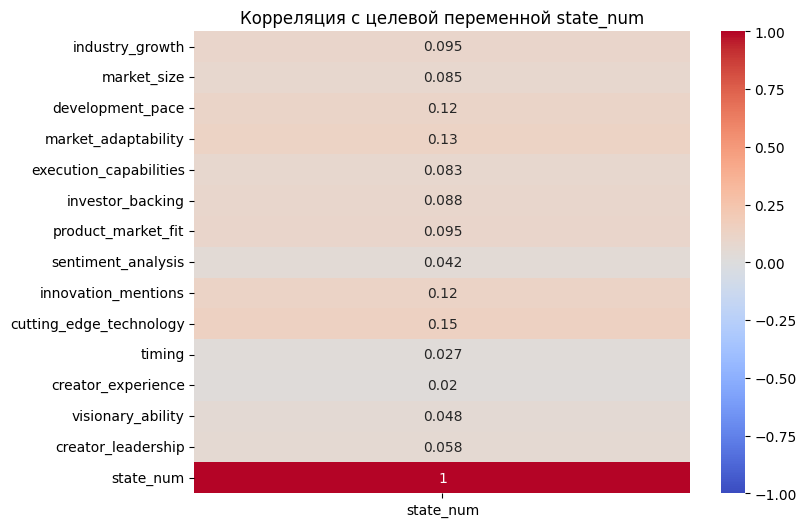

In [24]:
new_columns = encoded_df.columns.to_list()
new_columns.append('state_num')
numeric_columns = full_res.select_dtypes(include=['number']).columns.tolist()
categorical_columns = full_res.select_dtypes(exclude=['number']).columns.tolist()
# Корреляционный анализ

correlation_matrix = full_res[new_columns].corr()

# Выбор корреляции с целевой переменной 'state_num'
correlation_with_target = correlation_matrix[['state_num']]

# Построение тепловой карты корреляции
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция с целевой переменной state_num')
plt.show()

При построении кросс-таблицы видно, что модель распредилила фичи из описания создателя и проекта относительно равноразмерно (50/50)
    
При построении корреляционной матрицы видно, что значимость большинства фич не сильно велико (до 0,1), а корреляция положительная. Ввиду того, что анализ проводила модель gpt-3.5-turbo, то точность анализа может быть ниже, чем если бы модель gpt-4 и выше. Даже так, модель достаточно точно сможет предсказывать успешность


In [25]:
numeric_columns = full_res.select_dtypes(include=['number', 'bool']).columns.tolist()
categorical_columns = full_res.select_dtypes(exclude=['number']).columns.tolist()

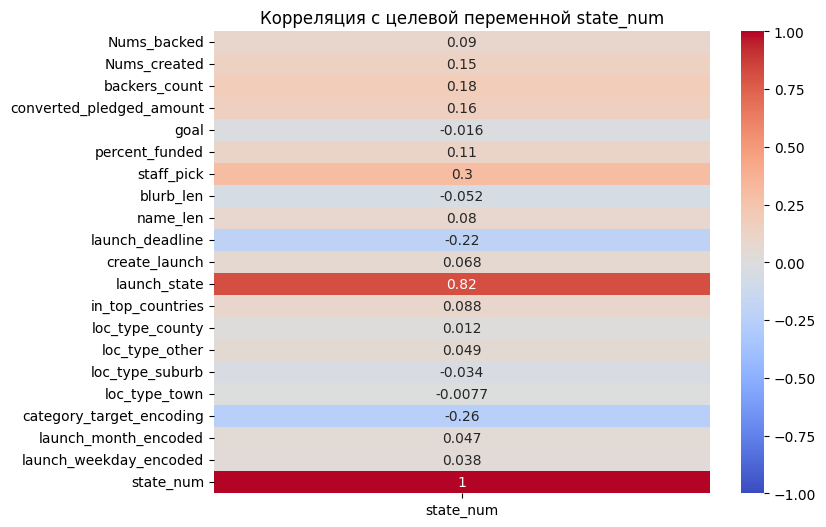

In [26]:
result = [item for item in numeric_columns if item not in new_columns]
result.append('state_num')
correlation_matrix = full_res[result].corr()

# Выбор корреляции с целевой переменной 'state_num'
correlation_with_target = correlation_matrix[['state_num']]

# Построение тепловой карты корреляции
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция с целевой переменной state_num')
plt.show()

In [27]:
# Выбираем следующие колонки на удаление
columns_to_drop = ['backers_count', 'converted_pledged_amount', 'percent_funded', 'launch_state']
df_tt = full_res[numeric_columns].drop(columns=columns_to_drop)
numeric_df_columns = df_tt.select_dtypes(include=['number', 'bool']).columns.tolist()
# Корреляционный анализ

In [28]:
numeric_df_columns = df_tt.select_dtypes(include=['number', 'bool']).columns.tolist()
correlation_matrix = df_tt[numeric_df_columns].corr()

# Выбор корреляции с целевой переменной 'state_num'
correlation_with_target = correlation_matrix['state_num'].abs().sort_values(ascending=False)
columns_to_train = correlation_with_target[correlation_with_target > 0.05]

In [29]:
# Обучим начальную модель на фичах из бейзлайна
new_columns = encoded_df.columns.to_list()
new_columns.append('state_num')

def evaluate_metrics(y_true, y_pred, model):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"{model}: Accuracy={accuracy:.3f}, F1-Score={f1:.3f}, ROC-AUC={roc_auc:.3f}")
    return accuracy, f1, roc_auc

def measure_inference_time(model, X, n_runs=100):
    total_time = 0
    for _ in range(n_runs):
        start_time = time.time()  # Запоминаем начальное время
        _ = model.predict(X)  # Выполняем предсказание
        total_time += (time.time() - start_time)  # Измеряем прошедшее время

    average_time = total_time / n_runs  # Среднее время вывода
    return average_time

Обучим модель RandomForest, которая на безлайне показывала лучший результат и найдем самые важные фичи


In [62]:
X = df_tt.drop(columns=['state_num'])
y = df_tt['state_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'n_estimators': [150],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(max_depth=20, min_samples_leaf= 1, min_samples_split=5, n_estimators=150, random_state=42)
rf.fit(X_train, y_train)

rf_importances = rf.feature_importances_
feature_names = X.columns

In [64]:
rf_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importances
})

rf_importance_df = rf_importance_df.sort_values(by='importance', ascending=False)

# Вывод топ-10 признаков
print("Top 20 features for Random Forest:")
print(rf_importance_df.head(20))
important_features = rf_importance_df.head(20)['feature'].tolist()
important_features.append('state_num')

Top 20 features for Random Forest:
                     feature  importance
13  category_target_encoding        0.14
7              create_launch        0.12
6            launch_deadline        0.09
2                       goal        0.09
3                 staff_pick        0.06
4                  blurb_len        0.05
1               Nums_created        0.05
14      launch_month_encoded        0.05
5                   name_len        0.04
19       market_adaptability        0.04
15    launch_weekday_encoded        0.03
20    execution_capabilities        0.02
27        creator_experience        0.02
17               market_size        0.02
22        product_market_fit        0.02
0                Nums_backed        0.02
25   cutting_edge_technology        0.02
18          development_pace        0.02
24       innovation_mentions        0.01
28         visionary_ability        0.01


Сейчас построим для данных с выделенными по важности 20 признаками, в которые также входят новые фичи

In [128]:
df_tt_new = df_tt[important_features]
X = df_tt_new.drop(columns=['state_num'])
y = df_tt_new['state_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Применение SMOTE для оверсэмплинга миноритарного класса
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

rf = RandomForestClassifier(max_depth=20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150, random_state=42)
rf.fit(X_train, y_train)
y_pred_best_rf = rf.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))



c:\ДЗ\Python Projects\DL\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.52      0.59        73
           1       0.85      0.92      0.89       223

    accuracy                           0.82       296
   macro avg       0.77      0.72      0.74       296
weighted avg       0.81      0.82      0.82       296

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.30      0.41        73
           1       0.81      0.95      0.87       223

    accuracy                           0.79       296
   macro avg       0.73      0.62      0.64       296
weighted avg       0.77      0.79      0.76       296

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        73
           1       0.87      0.97      0.92       223

    accuracy                           0.87       296
   macro av

Decision Tree: Accuracy=0.814, F1-Score=0.878, ROC-AUC=0.743
Logistic Regression: Accuracy=0.770, F1-Score=0.857, ROC-AUC=0.622
Random Forest+GS: Accuracy=0.845, F1-Score=0.900, ROC-AUC=0.763
                 Model  Accuracy  F1-Score  ROC-AUC
0        Decision Tree      0.81      0.88     0.74
1  Logistic Regression      0.77      0.86     0.62
2     Random Forest+GS      0.84      0.90     0.76


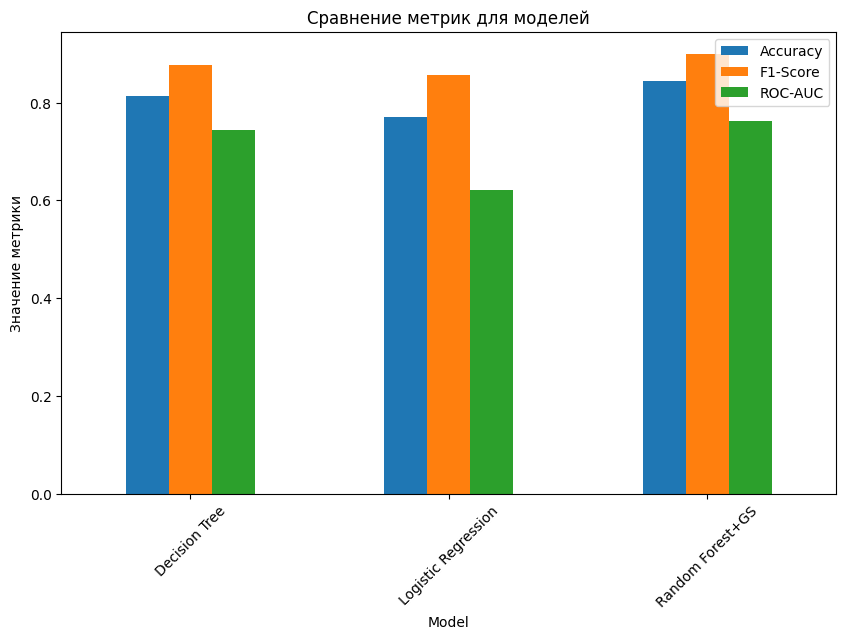

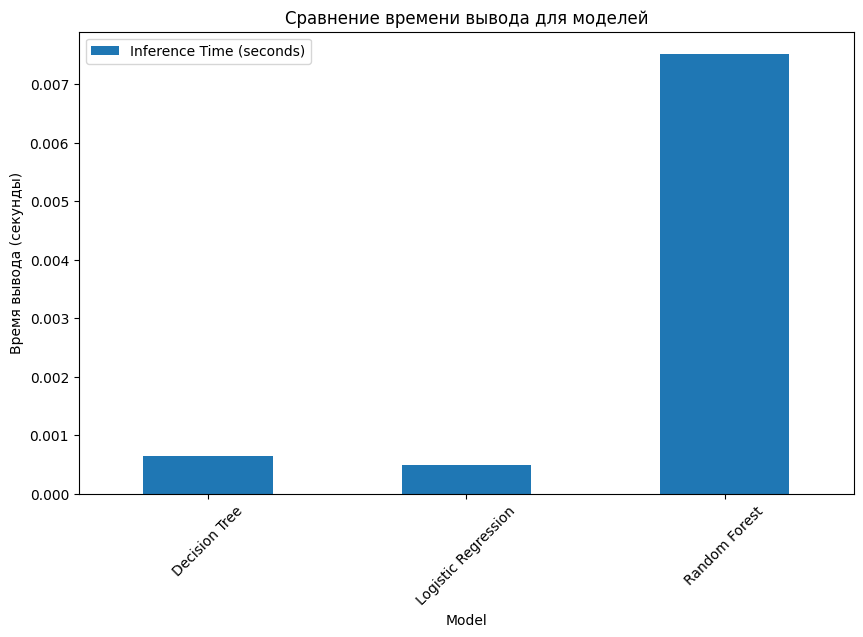

In [126]:
inference_dt = measure_inference_time(decision_tree, X_test)
inference_lr = measure_inference_time(log_reg, X_test)
inference_rf = measure_inference_time(rf, X_test)

metrics_dt = evaluate_metrics(y_test, y_pred_dt, "Decision Tree")
metrics_lr = evaluate_metrics(y_test, y_pred_lr, "Logistic Regression")
metrics_best_rf = evaluate_metrics(y_test, y_pred_best_rf, "Random Forest+GS")

# Сравнение метрик
metrics_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'Random Forest+GS'],
    'Accuracy': [metrics_dt[0], metrics_lr[0], metrics_best_rf[0]],
    'F1-Score': [metrics_dt[1], metrics_lr[1], metrics_best_rf[1]],
    'ROC-AUC': [metrics_dt[2], metrics_lr[2], metrics_best_rf[2]]
})

print(metrics_df)

# Визуализация
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Сравнение метрик для моделей')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45)
plt.show()

inference_metrics_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'Random Forest'],
    'Inference Time (seconds)': [inference_dt, inference_lr, inference_rf]
})

inference_metrics_df.set_index('Model', inplace=True)
inference_metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Сравнение времени вывода для моделей')
plt.ylabel('Время вывода (секунды)')
plt.xticks(rotation=45)
plt.show()

Попробуем построить Pipline с доп.обработкой

In [151]:
# Датасет со всеми фичами добавленными фичами
X = df_tt.drop(columns=['state_num'])
y = df_tt['state_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_best_rf = rf.predict(X_test)

print("Random Forest + New Features Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f'CV MEAN and STD{scores.mean(), scores.std()}')

print()
# Датасет со всеми фичами + scaler
df_tt_new = df_tt[important_features]
X = df_tt_new.drop(columns=['state_num'])
y = df_tt_new['state_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth=20,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=150,
                                  random_state=42))
])

pipe.fit(X_train, y_train)
y_pred_pipe = pipe.predict(X_test)

print("Random Forest + IMP_FEATURES Classification Report:")
print(classification_report(y_test, y_pred_pipe))

scores = cross_val_score(pipe, X_train, y_train, cv=5)
print(f'CV MEAN and STD{scores.mean(), scores.std()}')

Random Forest + New Features Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        73
           1       0.87      0.97      0.92       223

    accuracy                           0.87       296
   macro avg       0.87      0.77      0.80       296
weighted avg       0.87      0.87      0.86       296

CV MEAN and STD(0.8486733891153543, 0.01690557244698858)

Random Forest + IMP_FEATURES Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        73
           1       0.88      0.96      0.92       223

    accuracy                           0.87       296
   macro avg       0.85      0.77      0.80       296
weighted avg       0.86      0.87      0.86       296

CV MEAN and STD(0.8580097260959736, 0.01768386268115541)


## Сравнение Моделей Классификации  

Общая производительность
Оба подхода имеют одинаковую точность (accuracy) на уровне **87%**, что говорит о том, что обе модели хорошо справляются с задачей классификации.
Precision
- **Класс 0**: Модель с новыми признаками имеет более высокую точность (0.86 против 0.83).
- **Класс 1**: Модель с важными признаками немного лучше (0.88 против 0.87).
Recall
- **Класс 1**: Recall выше в обеих моделях, но модель с новыми признаками имеет лучший recall для класса 1 (97% против 96%).
- **Класс 0**: Recall остается на одинаковом уровне (58% против 59%).
F1-Score
F1-Score одинаков для обеих моделей.
Macro и Weighted Average
- **Macro Average**: Модель с новыми признаками имеет более высокую точность и recall по сравнению с моделью с важными признаками.
Кросс-валидация
Среднее значение кросс-валидации для модели с новыми признаками ниже (≈0.849) по сравнению с моделью с важными признаками (≈0.858). Это может указывать на то, что модель с важными признаками более устойчива к изменениям в данных.

Заключение
Обе модели показывают хорошие результаты, но есть некоторые различия:
- Модель с новыми признаками демонстрирует лучшую точность для класса 0, но хуже по среднему значению кросс-валидации.
- Модель с важными признаками имеет более стабильные результаты по кросс-валидации, что может быть важным фактором при выборе модели.

## Анализ качества двух моделей на основе отчета классификации

Модели:
- (Модель 1): Модель с отбором важных признаков.
- (Модель 2): Модель c бейзлайна.

3. Подробный анализ метрик:
Точность (precision):
- **Модель 1**: Выше для обоих классов (0.83 и 0.88) по сравнению с Моделью 2 (0.74 и 0.82).
- **Вывод**: Модель 1 лучше распознает положительные и отрицательные классы, снижая ложные срабатывания.
Полнота (recall):
- Для класса 1 (основной класс) у обеих моделей высокие значения, но у **Модели 1** полнота выше (0.96 против 0.91 у Модели 2).
- Для класса 0 **Модель 1** имеет лучшее значение полноты (0.59 против 0.57).
F1-мера:
- **Модель 1**: F1-мера выше для обоих классов (0.69 и 0.92) по сравнению с Моделью 2 (0.64 и 0.86).
- **Вывод**: Модель 1 обеспечивает более сбалансированные результаты между точностью и полнотой.
Общая точность (accuracy):
- **Модель 1**: 0.87, что выше по сравнению с Моделью 2 (0.80).
- **Вывод**: Модель 1 лучше справляется с общей задачей классификации.
Средние макро и взвешенные метрики:
- **Модель 1**: Макро и взвешенные метрики (точность и полнота) выше, что подтверждает её преимущество в общей сбалансированности.

4. Заключение:
- **Модель 1** (Random Forest + IMP_FEATURES) значительно превосходит **Модель 2** по всем основным метрикам: точности, полноте и F1-мере.
- Использование отобранных признаков даёт значительное улучшение качества классификации, что делает **Модель 1** предпочтительным выбором для задачи.